In [16]:
import re
import glob
import os
import json
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
runs=1
dispatch_dfs = []
rays_dfs = []

In [18]:
# Process Swift DispatchBenchmark files
for run in range(1, runs+1):
    for file in glob.glob(f'benchmark-results/{run}/Current_run.DispatchBenchmark.*.wallClock.histogram.samples.tsv'):
        base = os.path.basename(file)
        # Example file name:
        # Current_run.DispatchBenchmark.dispatchExistential(classCount:14).wallClock.histogram.samples.tsv
        m = re.search(r'DispatchBenchmark.dispatch([A-Za-z]+)\(classCount:([0-9]+)\)', base)

        df = pd.read_csv(file, sep='\t').rename(columns={'Time (wall clock) (μs)': 'Time (μs)'})

        df['Class count'] = int(m.group(2))
        df['Version'] = "Swift " + m.group(1)
        df['Run'] = run

        dispatch_dfs.append(df)

In [19]:
# Process Swift RaysBenchmark files
for run in range(1, runs+1):
    for file in glob.glob(f'benchmark-results/{run}/Current_run.RaysBenchmark.*.wallClock.histogram.samples.tsv'):
        base = os.path.basename(file)
        # Example file name:
        # Current_run.RaysBenchmark.runExistential(shapeCount:1000).wallClock.histogram.samples.tsv
        m = re.search(r'RaysBenchmark.run([A-Za-z]+)\(shapeCount:([0-9]+)\)', base)

        df = pd.read_csv(file, sep='\t').rename(columns={'Time (wall clock) (μs)': 'Time (μs)'})

        df['Version'] = "Swift " + m.group(1)
        df['Run'] = run

        rays_dfs.append(df)

In [20]:
# Process JMH file
for run in range(1, runs+1):
    for bench in json.load(open(f'benchmark-results/{run}/scala.json')):
        name_parts = bench["benchmark"].split('.')
        values = [int(x) for x in bench["primaryMetric"]["rawData"][0]] # converts to ints for coherence with Swift
        df = pd.DataFrame(values, columns=['Time (μs)'])
        df['Run'] = run
        if name_parts[2] == "DispatchBenchmark":
            df['Class count'] = int(bench["params"]["classCount"])
            df['Version'] = "Scala " + name_parts[-1][9:] # removes the "benchmark" prefix
            dispatch_dfs.append(df)
        elif name_parts[2] == "RaysBenchmark":
            df['Version'] = "Scala " + name_parts[-1][9:] # removes the "benchmark" prefix
            rays_dfs.append(df)

In [21]:
dispatch = pd.concat(dispatch_dfs, ignore_index=True)
dispatch["Time (ms)"] = dispatch["Time (μs)"] / 1000
dispatch

,Time (μs),Class count,Version,Run
0,4.780,2,Swift Existential,1
1,4.780,2,Swift Existential,1
2,4.780,2,Swift Existential,1
3,4.780,2,Swift Existential,1
4,4.780,2,Swift Existential,1
...,...,...,...,...
39995,3.747,20,Scala Inheritance,1
39996,3.725,20,Scala Inheritance,1
39997,4.260,20,Scala Inheritance,1
39998,4.217,20,Scala Inheritance,1


In [22]:
rays = pd.concat(rays_dfs, ignore_index=True)
rays["Time (ms)"] = rays["Time (μs)"] / 1000
rays

,Time (μs),Version,Run,Time (ms)
0,23118,Swift Existential,1,23.118
1,23134,Swift Existential,1,23.134
2,23134,Swift Existential,1,23.134
3,23134,Swift Existential,1,23.134
4,23151,Swift Existential,1,23.151
...,...,...,...,...
3995,41072,Scala Inheritance,1,41.072
3996,48143,Scala Inheritance,1,48.143
3997,47877,Scala Inheritance,1,47.877
3998,42792,Scala Inheritance,1,42.792


In [23]:
fig = px.box(dispatch, x='Class count', y='Time (ms)', color='Version', title='Dispatch Benchmark', points=False)
fig.update_layout(xaxis=dict(tickmode='array', tickvals=dispatch['Class count'].unique()))
fig

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['Time (μs)', 'Class count', 'Version', 'Run'] but received: Time (ms)

In [ ]:
px.violin(rays, x='Time (ms)', color='Version', title='Rays Benchmark', orientation='h', height=800)

In [ ]:
sns.set_style("whitegrid")

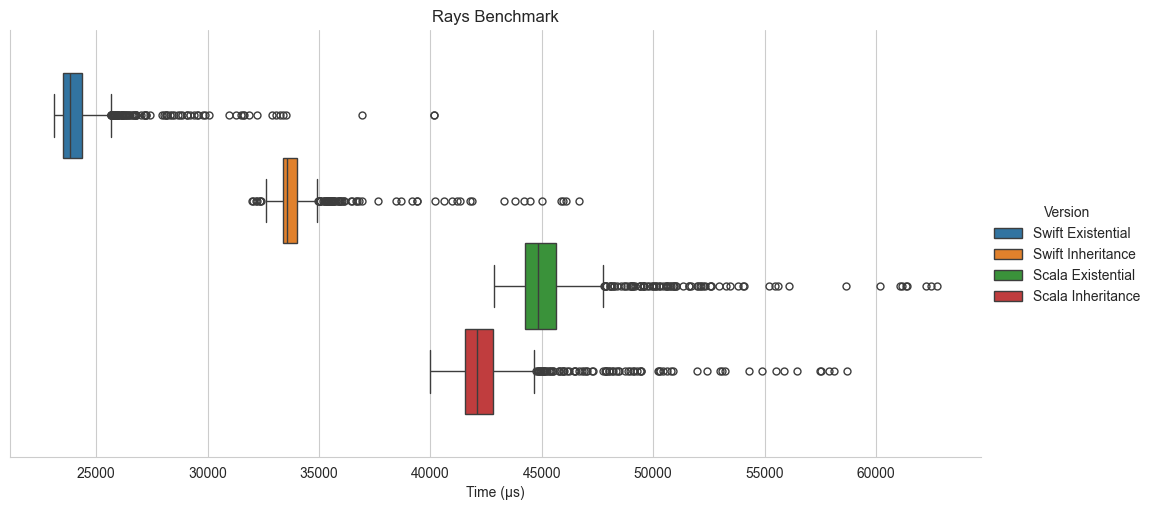

In [ ]:
sns.catplot(data=rays, x='Time (ms)', hue='Version', kind="box", height=5, aspect=2)
plt.title('Rays Benchmark')
plt.show()

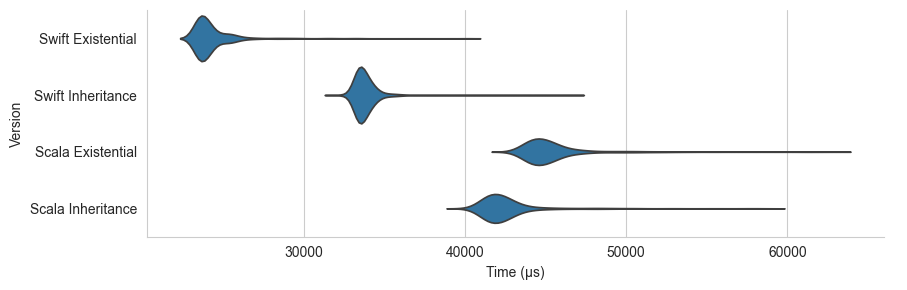

In [ ]:
sns.catplot(data=rays, x='Time (ms)', y='Version', kind="violin", height=3, aspect=3, orient='h', inner=None, width=1)

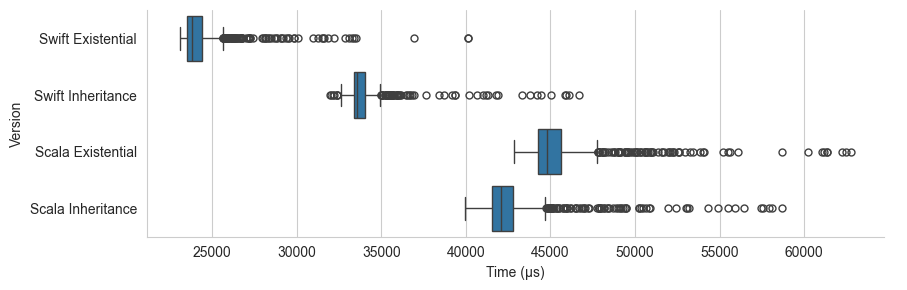

In [ ]:
sns.catplot(data=rays, x='Time (ms)', y='Version', kind="box", height=3, aspect=3, orient='h')

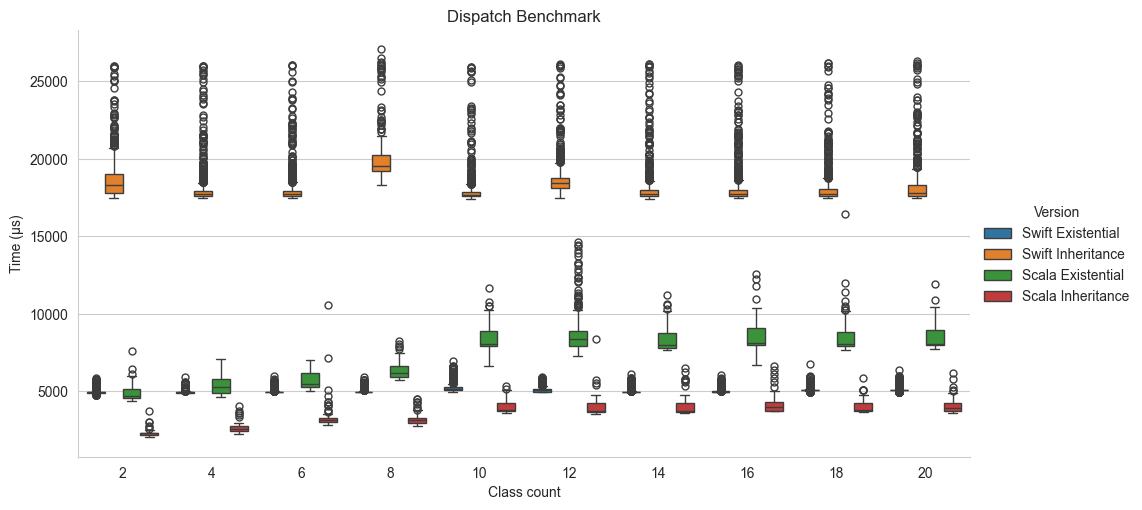

In [ ]:
sns.catplot(data=dispatch, x='Class count', y='Time (ms)', hue='Version', kind="box", height=5, aspect=2)
plt.title('Dispatch Benchmark')
plt.show()

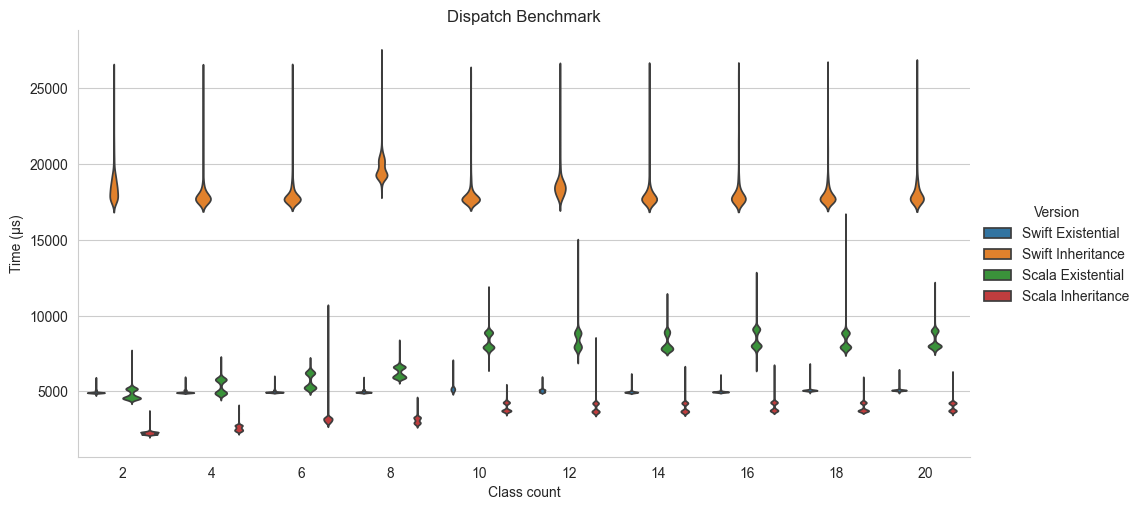

In [ ]:
sns.catplot(data=dispatch, x='Class count', y='Time (ms)', hue='Version', kind="violin", height=5, aspect=2, inner=None)
plt.title('Dispatch Benchmark')
plt.show()